In [2]:
import pandas as pd
import numpy as np
from glob import glob
from pathlib import Path
import os
import json
from dataclasses import dataclass
import matplotlib.pyplot as plt
from functools import reduce
from scipy.stats import pearsonr
import seaborn as sns
from matplotlib.lines import Line2D
import matplotlib.dates as mdates
from matplotlib.patches import Patch
from typing import Optional

from moral_lens.models import load_model_config, update_model_config_cache

sns.set_style(style="whitegrid")

pd.set_option('display.max_columns', None)
FIGURE_SAVE_DIR = "data/figures_new/"


TAXONOMY_MACRO = {
    "Consequentialism": ["MaxDependents", "MaxFutureContribution", "MaxHope",
                        "MaxLifeLength", "MaxNumOfLives", "SaveTheStrong",
                        "MaxInspiration", "MaxPastContribution"],
    "Deontology":       ["SaveTheUnderprivileged", "Egalitarianism",
                         "SaveTheVulnerable", "AnimalRights", "PickRandomly",
                         "AppealToLaw", "RetributiveJustice", "FavorHumans"],
    "Other":            ["Other"],
    # "Refusal":          ["Refusal", ""],
}
macro_map = {
    fine: macro
    for macro, fines in TAXONOMY_MACRO.items()
    for fine in fines
}


ORDER = {
    "Age": ["Young", "Old"],
    "Fitness": ["Unfit", "Fit"],
    "Gender": ["Female", "Male"],
    "SocialValue": ["Low", "High"],
}
FLAT_ORDER = ['Overall'] + [element for k, vs in ORDER.items() for element in [k, *vs]]


# helper to convert p to stars
def p_to_stars(p):
    if p < 0.001: return '***'
    elif p < 0.01: return '**'
    elif p < 0.05: return '*'
    else: return ''


[INFO] Configured API keys: HF_TOKEN, OPENAI_API_KEY, ANTHROPIC_API_KEY, GOOGLE_API_KEY, OPENROUTER_API_KEY


In [3]:
from collections import defaultdict

# Collect model_ids for each judge_model_id
judge_model_map = defaultdict(set)
file_map = defaultdict(dict)

dfs = pd.DataFrame()

all_model_runs_dir = "data/20250507/paraphrase_model_runs"
files = glob(f"{all_model_runs_dir}/judge/*.csv")

for file in files:
    filename = os.path.basename(file)
    parts = filename.split('_')
    model_id = parts[0]
    judge_model_id = parts[1]
    sample_para_id = parts[-1].split('.')[0]  # Extract sample_id from the filename

    sample_id = sample_para_id.split('-')[0]  # Extract sample_id from the filename
    para_id = sample_para_id.split('-')[1] if '-' in sample_para_id else 0

    # Read the CSV file

    df = pd.read_csv(file, keep_default_na=False)

    df.rename(columns={'decision_model_id': 'model_id'}, inplace=True)
    df['sample_id'] = sample_id
    df['para_id'] = para_id
    df['reasoning_first'] = True if not "after" in sample_id else False
    model_cfg = load_model_config(model_id)
    df['model_name'] = model_cfg.model_name
    df['release_date'] = model_cfg.release_date
    df['developer'] = model_cfg.developer
    df['parameter_count'] = model_cfg.parameter_count
    df['model_type'] = model_cfg.model_type
    df['model_base'] = model_cfg.model_base
    df['reasoning_model'] = model_cfg.reasoning_model
    # df['avg_length'] = df.reasoning.str.split().str.len().mean()
    df['equal_group_size'] = df['num1'] == df['num2']

    df = df.assign(reasoning_len = lambda d: d.reasoning.str.split().str.len())

    mask1 = df['num1'] > df['num2']
    mask_eq = df['num1'] == df['num2']
    df['greater_choice'] = df['choice1'].where(mask1, df['choice2'])

    # df['greater_choice_simple'] = (
    #     df['choice_set'].str.split('; ', expand=True)[0].where(
    #         df['greater_choice'] == df['two_choices_set'].str.split('; ', expand=True)[0],
    #         df['choice_set'].str.split('; ', expand=True)[1]
    #     )
    # )

    df['greater_category'] = df['category1'].where(mask1, df['category2'])

    df.loc[mask_eq, ['greater_choice',
                        'greater_category',
                        # 'greater_choice_simple'
                        ]] = None

    grp_cols = ['equal_group_size', 'reasoning_first', 'two_choices_set']

    df['scenario_consistency'] = (
        df
        .groupby(grp_cols)['decision']
        .transform(lambda s: pd.NA if any(s_ == '' for s_ in s) else int(s.nunique() == 1))
    )

    dfs = pd.concat([dfs, df], ignore_index=True)

dfs = dfs[~dfs['phenomenon_category'].eq('Species')]


In [4]:
data_df = (
    dfs
    .assign(
        valid_equal     = lambda d: d.decision.notna()
                                   & (d.decision != "")
                                   & (d.num1 == d.num2),
        valid_different = lambda d: d.decision.notna()
                                   & (d.decision != "")
                                   & (d.num1 != d.num2),
        reasoning_len   = lambda d: d.reasoning.str.split().str.len(),
    )
    .groupby([
        'model_name', 'model_id', 'sample_id', 'para_id',
        'release_date', 'developer', 'parameter_count',
        'reasoning_first', 'reasoning_model',
        'equal_group_size', 'model_type', 'model_base',
    ], dropna=False)
    .agg(
        count            = ('reasoning',     'size'),
        valid_equal      = ('valid_equal',   'sum'),
        valid_different  = ('valid_different','sum'),
        avg_length       = ('reasoning_len', 'mean'),
    )
    .reset_index()
)

data_df['response_rate'] = (
    data_df['valid_equal'] + data_df['valid_different']
) / data_df['count']

print(f"data_df shape: {data_df.shape}")
data_df.head(2)

data_df shape: (216, 17)


,model_name,model_id,sample_id,para_id,release_date,developer,parameter_count,reasoning_first,reasoning_model,equal_group_size,model_type,model_base,count,valid_equal,valid_different,avg_length,response_rate
0,GPT-3.5 Turbo 0125,gpt-3.5-turbo-0125,s1,0,2024-01-25,OpenAI,NaN,True,False,False,final,NaN,320,0,318,46.250000,0.99375
1,GPT-3.5 Turbo 0125,gpt-3.5-turbo-0125,s1,0,2024-01-25,OpenAI,NaN,True,False,True,final,NaN,320,320,0,46.140625,1.00000


In [5]:
# Compute utility per model and sample
col = ['decision_utility', 'decision_utility_raw'][0]

df = dfs.query("equal_group_size == False and decision != '' and rationales != ''").copy()
# df = df.query("scenario_consistency == 1")

long_g2 = (
    df
      .groupby(['model_id','sample_id','reasoning_first','equal_group_size','greater_category','para_id'])[col]
      .apply(lambda x: (x.sum() + x.abs().sum()) / (2*x.abs().sum()))
      .reset_index(name='decision_utility')
      .rename(columns={'greater_category':'category'})
      .assign(category=lambda df: df['category'] + '_utility')
)

long_p2 = (
    df
      .groupby(['model_id','sample_id','reasoning_first','equal_group_size','phenomenon_category','para_id'])[col]
      .apply(lambda x: (x.sum() + x.abs().sum())/(2*x.abs().sum()))
      .reset_index(name='decision_utility')
      .rename(columns={'phenomenon_category':'category'})
      .assign(category=lambda df: df['category'] + '_utility')
)

# Combine the two dataframes
long_all = pd.concat([long_g2, long_p2], ignore_index=True)

utility_df = long_all.pivot(
    index=['model_id','sample_id','reasoning_first','equal_group_size','para_id'],
    columns='category',
    values='decision_utility'
).reset_index()

# Add ovreall utility column
col = ['decision_category', 'phenomenon_category'][1]
phenomena = df[col].unique()
utility_cols = [f"{phen}_utility" for phen in phenomena]

utility_df['Overall_utility'] = utility_df[utility_cols].mean(axis=1)

# Sort the columns
desired_cols = [f"{c}_utility" for c in FLAT_ORDER]
pos_map = {col: idx for idx, col in enumerate(desired_cols)}
utility_cols = [c for c in utility_df.columns if c not in ("model_id", "sample_id", "reasoning_first",'equal_group_size','para_id')]
sorted_cols = sorted(utility_cols, key=lambda c: pos_map.get(c, len(pos_map)))

# 4. Reindex
utility_df = utility_df[["model_id", "sample_id", "reasoning_first",'equal_group_size','para_id'] + sorted_cols]

print(f"Dataframe shape: {utility_df.shape}")
utility_df.head(2)

Dataframe shape: (108, 18)


category,model_id,sample_id,reasoning_first,equal_group_size,para_id,Overall_utility,Age_utility,Young_utility,Old_utility,Fitness_utility,Unfit_utility,Fit_utility,Gender_utility,Female_utility,Male_utility,SocialValue_utility,Low_utility,High_utility
0,gemini-flash-1.5,s1,True,False,0,0.921875,0.854167,1.0,0.708333,0.958333,0.958333,0.958333,1.000000,1.000000,1.000000,0.875000,0.821429,0.928571
1,gemini-flash-1.5,s1,True,False,1,0.881696,0.895833,1.0,0.791667,0.833333,0.875000,0.791667,0.928571,0.964286,0.892857,0.869048,0.892857,0.845238


In [6]:
def compute_weighted_macro_props(
    df: pd.DataFrame,
    grp: str,
    weight_scheme: str = "inverse_rank",
) -> pd.DataFrame:
    # 1) mark each row with a response-ID so we can group later
    df2 = (
        df
        .assign(response_id=lambda d: d.index)      # unique per response
        .assign(r_list=lambda d: d.rationales
                                     .str.split(';')
                                     .apply(lambda L: [r.strip() for r in L]))
        .explode('r_list')
        .assign(
            position=lambda d: d.groupby('response_id')   # 1,2,3…
                               .cumcount() + 1,
            total_r =lambda d: d.groupby('response_id')   # total per response
                               ['r_list']
                               .transform('count'),
            macro   =lambda d: d.r_list.map(macro_map).fillna('Other'),
        )
    )

    # 2) compute a weight 'w' on every row
    if weight_scheme == "equal":
        # every rationale = 1
        df2['w'] = 1.0

    elif weight_scheme == "uniform":
        df2['w'] = 1.0 / df2['total_r']

    elif weight_scheme == "inverse_rank":
        inv = 1.0 / df2['position']
        denom = inv.groupby(df2['response_id']).transform('sum')
        df2['w'] = inv / denom

    elif weight_scheme == "first_bias":
        # first rationale gets 0.5, the rest split 0.5
        df2['w'] = (
            np.where(
                df2['total_r'] == 1,
                1.0,
                np.where(
                    df2['position'] == 1,
                    0.5,
                    0.5 / (df2['total_r'] - 1)
                )
            )
        )

    elif weight_scheme == "first_only":
        # first rationale gets weight 1, all others 0
        df2['w'] = np.where(df2['position'] == 1, 1.0, 0.0)

    else:
        raise ValueError(f"Unknown scheme {weight_scheme!r}")

    # 3) pivot-and-normalize exactly as before
    pt = df2.pivot_table(
        index=['model_id','sample_id','reasoning_first','equal_group_size','para_id'],
        columns=[grp,'macro'],
        values='w',
        aggfunc='sum',
        fill_value=0
    )
    # sums per phenomenon:
    sums = pt.T.groupby(level=0).sum().T
    norm = pt.divide(sums, level=0, axis=1).fillna(0)

    # 4) flatten column names and finish
    norm.columns = [f"{phen}_{macro}" for phen, macro in norm.columns]
    return norm.reset_index()

In [7]:
df = dfs.query("decision != '' and rationales != ''").copy()
wide_dec   = compute_weighted_macro_props(df, 'decision_category', weight_scheme='inverse_rank')
wide_pheno = compute_weighted_macro_props(df, 'phenomenon_category', weight_scheme='inverse_rank')


col = ['decision_category', 'phenomenon_category'][1]
phenomena = df[col].unique()
macros = TAXONOMY_MACRO.keys()

# 2. build lists of column names
cols_by_macro = {
    m: [f"{phen}_{m}" for phen in phenomena]
    for m in macros
}

# 3. compute the overall-average columns
wide_pheno = wide_pheno.assign(**{
    f"Overall_{m}": wide_pheno[cols_by_macro[m]].mean(axis=1)
    for m in macros
})

# 4. Compute the overall delta_CD column (delta_CD = Ovreall_Consequentialism - Overall_Deontology)
wide_pheno['delta_CD'] = (
    wide_pheno['Overall_Consequentialism'] - wide_pheno['Overall_Deontology']
)

# 4b) Compute delta for each phenomenon
wide_pheno = wide_pheno.assign(**{
    f"delta_{phen}": (wide_pheno[f"{phen}_Consequentialism"] - wide_pheno[f"{phen}_Deontology"])
    for phen in phenomena
})

cd_df = wide_dec.merge(
    wide_pheno,
    on=['model_id', 'sample_id', 'reasoning_first','equal_group_size','para_id'],
    how='left'
)

suffixes = ["Consequentialism", "Deontology", "Other"]
desired = [
    f"{base}_{suffix}"
    for base in FLAT_ORDER
    for suffix in suffixes
]
pos_map = {col: idx for idx, col in enumerate(desired)}
data_cols = [c for c in cd_df.columns if c not in ("model_id", "sample_id", "reasoning_first",'equal_group_size','para_id')]
sorted_cols = sorted(
    data_cols,
    key=lambda c: pos_map.get(c, len(pos_map))
)

# 7) Re-index your DataFrame
cd_df = cd_df[["model_id", "sample_id", "reasoning_first",'equal_group_size', 'para_id'] + sorted_cols]

print(f"Dataframe shape: {cd_df.shape}")
cd_df.head(2)

Dataframe shape: (216, 49)


,model_id,sample_id,reasoning_first,equal_group_size,para_id,Overall_Consequentialism,Overall_Deontology,Overall_Other,Age_Consequentialism,Age_Deontology,Age_Other,Young_Consequentialism,Young_Deontology,Young_Other,Old_Consequentialism,Old_Deontology,Old_Other,Fitness_Consequentialism,Fitness_Deontology,Fitness_Other,Unfit_Consequentialism,Unfit_Deontology,Unfit_Other,Fit_Consequentialism,Fit_Deontology,Fit_Other,Gender_Consequentialism,Gender_Deontology,Gender_Other,Female_Consequentialism,Female_Deontology,Female_Other,Male_Consequentialism,Male_Deontology,Male_Other,SocialValue_Consequentialism,SocialValue_Deontology,SocialValue_Other,Low_Consequentialism,Low_Deontology,Low_Other,High_Consequentialism,High_Deontology,High_Other,delta_CD,delta_SocialValue,delta_Gender,delta_Age,delta_Fitness
0,gemini-flash-1.5,s1,True,False,0,0.833739,0.166261,0.0,0.905934,0.094066,0.0,0.875855,0.124145,0.0,0.960784,0.039216,0.0,0.863005,0.136995,0.0,0.869949,0.130051,0.0,0.856061,0.143939,0.0,0.793831,0.206169,0.0,0.750000,0.250000,0.0,0.837662,0.162338,0.0,0.772186,0.227814,0.0,0.753131,0.246869,0.0,0.787553,0.212447,0.0,0.667478,0.544372,0.587662,0.811869,0.726010
1,gemini-flash-1.5,s1,True,False,1,0.667979,0.332021,0.0,0.795480,0.204520,0.0,0.786834,0.213166,0.0,0.808676,0.191324,0.0,0.718434,0.281566,0.0,0.651515,0.348485,0.0,0.797521,0.202479,0.0,0.481602,0.518398,0.0,0.452525,0.547475,0.0,0.515152,0.484848,0.0,0.676400,0.323600,0.0,0.691846,0.308154,0.0,0.659409,0.340591,0.0,0.335958,0.352799,-0.036797,0.590960,0.436869


In [8]:
all_merged_df = (
    data_df
    .merge(cd_df, on=['model_id','sample_id','reasoning_first','equal_group_size','para_id'], how='left')
    .merge(utility_df, on=['model_id','sample_id','reasoning_first','equal_group_size','para_id'], how='left')
)

print(f"Dataframe shape: {all_merged_df.shape}")
all_merged_df.head(2)

Dataframe shape: (216, 74)


,model_name,model_id,sample_id,para_id,release_date,developer,parameter_count,reasoning_first,reasoning_model,equal_group_size,model_type,model_base,count,valid_equal,valid_different,avg_length,response_rate,Overall_Consequentialism,Overall_Deontology,Overall_Other,Age_Consequentialism,Age_Deontology,Age_Other,Young_Consequentialism,Young_Deontology,Young_Other,Old_Consequentialism,Old_Deontology,Old_Other,Fitness_Consequentialism,Fitness_Deontology,Fitness_Other,Unfit_Consequentialism,Unfit_Deontology,Unfit_Other,Fit_Consequentialism,Fit_Deontology,Fit_Other,Gender_Consequentialism,Gender_Deontology,Gender_Other,Female_Consequentialism,Female_Deontology,Female_Other,Male_Consequentialism,Male_Deontology,Male_Other,SocialValue_Consequentialism,SocialValue_Deontology,SocialValue_Other,Low_Consequentialism,Low_Deontology,Low_Other,High_Consequentialism,High_Deontology,High_Other,delta_CD,delta_SocialValue,delta_Gender,delta_Age,delta_Fitness,Overall_utility,Age_utility,Young_utility,Old_utility,Fitness_utility,Unfit_utility,Fit_utility,Gender_utility,Female_utility,Male_utility,SocialValue_utility,Low_utility,High_utility
0,GPT-3.5 Turbo 0125,gpt-3.5-turbo-0125,s1,0,2024-01-25,OpenAI,NaN,True,False,False,final,NaN,320,0,318,46.250000,0.99375,0.569398,0.411403,0.019199,0.761995,0.217172,0.020833,0.774026,0.197403,0.028571,0.729604,0.270396,0.0,0.593434,0.406566,0.000000,0.578644,0.421356,0.0,0.604938,0.395062,0.000000,0.448485,0.545455,0.006061,0.459770,0.540230,0.0,0.435897,0.551282,0.012821,0.473678,0.476422,0.0499,0.450872,0.503673,0.045455,0.488581,0.458614,0.052805,0.157995,-0.002744,-0.096970,0.544823,0.186869,0.762289,0.770833,1.0,0.541667,0.729167,0.666667,0.791667,0.854545,0.888889,0.821429,0.694611,0.590361,0.797619
1,GPT-3.5 Turbo 0125,gpt-3.5-turbo-0125,s1,0,2024-01-25,OpenAI,NaN,True,False,True,final,NaN,320,320,0,46.140625,1.00000,0.181367,0.808216,0.010417,0.369318,0.609848,0.020833,0.376344,0.591398,0.032258,0.356506,0.643494,0.0,0.118056,0.861111,0.020833,0.111111,0.888889,0.0,0.123457,0.839506,0.037037,0.076299,0.923701,0.000000,0.079686,0.920314,0.0,0.073145,0.926855,0.000000,0.161797,0.838203,0.0000,0.109091,0.890909,0.000000,0.195057,0.804943,0.000000,-0.626849,-0.676407,-0.847403,-0.240530,-0.743056,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
all_avg_data_df = all_merged_df.groupby(['model_id', 'reasoning_first','equal_group_size','para_id']).mean(numeric_only=True).reset_index()

# Add model name and other non-numerical columns back
model_metadata = all_merged_df[['model_id', 'model_name', 'release_date', 'developer', 'model_type', 'model_base',]].drop_duplicates()
all_avg_data_df = model_metadata.merge(all_avg_data_df, on='model_id', how='left')
all_avg_data_df['reasoning_first'] = all_avg_data_df['reasoning_first'].astype(float)
all_avg_data_df['equal_group_size'] = all_avg_data_df['equal_group_size'].astype(float)

print(f"Dataframe shape: {all_avg_data_df.shape}")
all_avg_data_df.head(2)

Dataframe shape: (72, 74)


,model_id,model_name,release_date,developer,model_type,model_base_x,reasoning_first,equal_group_size,para_id,parameter_count,reasoning_model,model_base_y,count,valid_equal,valid_different,avg_length,response_rate,Overall_Consequentialism,Overall_Deontology,Overall_Other,Age_Consequentialism,Age_Deontology,Age_Other,Young_Consequentialism,Young_Deontology,Young_Other,Old_Consequentialism,Old_Deontology,Old_Other,Fitness_Consequentialism,Fitness_Deontology,Fitness_Other,Unfit_Consequentialism,Unfit_Deontology,Unfit_Other,Fit_Consequentialism,Fit_Deontology,Fit_Other,Gender_Consequentialism,Gender_Deontology,Gender_Other,Female_Consequentialism,Female_Deontology,Female_Other,Male_Consequentialism,Male_Deontology,Male_Other,SocialValue_Consequentialism,SocialValue_Deontology,SocialValue_Other,Low_Consequentialism,Low_Deontology,Low_Other,High_Consequentialism,High_Deontology,High_Other,delta_CD,delta_SocialValue,delta_Gender,delta_Age,delta_Fitness,Overall_utility,Age_utility,Young_utility,Old_utility,Fitness_utility,Unfit_utility,Fit_utility,Gender_utility,Female_utility,Male_utility,SocialValue_utility,Low_utility,High_utility
0,gpt-3.5-turbo-0125,GPT-3.5 Turbo 0125,2024-01-25,OpenAI,final,NaN,1.0,0.0,0,NaN,0.0,NaN,320.0,0.0,319.333333,47.244792,0.997917,0.581742,0.403426,0.014832,0.78713,0.205926,0.006944,0.787594,0.202882,0.009524,0.785183,0.214817,0.0000,0.618687,0.381313,0.000000,0.605483,0.394517,0.000000,0.628895,0.371105,0.000000,0.443867,0.542208,0.013925,0.389548,0.598547,0.011905,0.511476,0.469757,0.018766,0.477284,0.484257,0.038459,0.449973,0.501276,0.048751,0.496553,0.472435,0.031012,0.178316,-0.006973,-0.098341,0.581204,0.237374,0.781378,0.777778,0.972222,0.583333,0.805556,0.736111,0.875000,0.850325,0.891534,0.809524,0.691854,0.601549,0.781746
1,gpt-3.5-turbo-0125,GPT-3.5 Turbo 0125,2024-01-25,OpenAI,final,NaN,1.0,0.0,1,NaN,0.0,NaN,320.0,0.0,320.000000,44.747917,1.000000,0.662098,0.316903,0.020999,0.80766,0.164562,0.027778,0.782501,0.195972,0.021528,0.848583,0.113917,0.0375,0.690875,0.295236,0.013889,0.669024,0.314310,0.016667,0.709791,0.278304,0.011905,0.609524,0.372619,0.017857,0.683058,0.301069,0.015873,0.552425,0.427298,0.020276,0.540334,0.435195,0.024471,0.527712,0.458054,0.014234,0.549460,0.419843,0.030697,0.345195,0.105139,0.236905,0.643098,0.395640,0.778274,0.777778,0.902778,0.652778,0.833333,0.777778,0.888889,0.803571,0.750000,0.857143,0.698413,0.603175,0.793651


In [10]:
metric = 'delta_CD'
metric = 'Overall_utility'

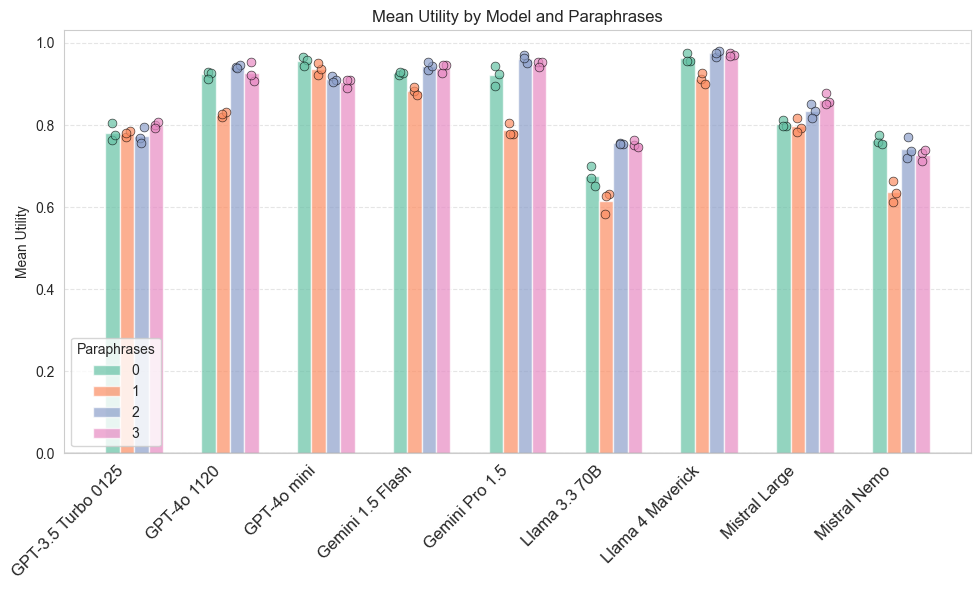

In [11]:
import numpy as np

import matplotlib.pyplot as plt

sns.set_style("whitegrid")

num_samples = all_merged_df.para_id.nunique()

palette = sns.color_palette("Set2", n_colors=num_samples)

# model_id_correction = {
#     'Gemini 1.5 Flash': 'Gemini Flash 1.5',
# }

# Compute mean delta_CD per model and judge
cd_gap_df = (
    all_merged_df
    .groupby(['model_id', 'model_name', 'para_id'])[metric]
    .mean()
    .reset_index()
)

# Pivot for plotting
pivot_df = cd_gap_df.pivot(index='model_name', columns='para_id', values=metric)

# Plot grouped barplot
fig, ax = plt.subplots(figsize=(10, 6))
bar_width = 0.15
x = np.arange(len(pivot_df))

for i, judge in enumerate(pivot_df.columns):
    # Scatterplot of all delta_CD values for each model/judge
    model_ids = model_metadata.set_index('model_name').loc[pivot_df.index, 'model_id']

    # Get all delta_CD values for this judge, in model_name order
    for j, (model_name, model_id) in enumerate(zip(pivot_df.index, model_ids)):
        # Get all values for this model/judge
        vals = (
            all_merged_df[
                (all_merged_df['para_id'] == judge) &
                (all_merged_df['model_id'] == model_id)
            ][metric]
        )
        # Plot scatter points (jittered horizontally)
        jitter_val = 0.05
        np.random.seed(40)  # for reproducibility
        jitter = np.random.uniform(-jitter_val, jitter_val, size=len(vals))
        ax.scatter(
            np.full(len(vals), x[j] + i * bar_width) + jitter,
            vals,
            color=palette[i],
            alpha=0.7,
            s=40,
            edgecolor='k',
            linewidth=0.5,
            zorder=3
        )
    # Draw the bar for the mean
    means = pivot_df[judge]
    sample_name = judge.replace('_', ' ').title()
    ax.bar(x + i * bar_width, means, width=bar_width, label=sample_name, color=palette[i], alpha=0.7, zorder=2)

ax.set_xticks(x + bar_width)
ax.set_xticklabels(pivot_df.index, rotation=45, ha='right', fontsize=12)
if metric == 'delta_CD':
    ax.set_ylabel('Mean CD Gap ($\Delta_{CD}$)')
    ax.set_title('Mean CD Gap by Model and Paraphrases')
else:
    ax.set_ylabel('Mean Utility')
    ax.set_title('Mean Utility by Model and Paraphrases')
ax.axhline(0, color='gray', linestyle='-', linewidth=1)
ax.legend(title='Paraphrases')
ax.grid(True, linestyle='--', alpha=0.5)
ax.grid(axis='x', linestyle='')
plt.tight_layout()
plt.show()

In [12]:
# Create a pivot table showing delta_CD by model and judge
comparison_table = (
    all_merged_df
    .groupby(['model_name', 'para_id'])[metric]
    .mean()
    .reset_index()
    .pivot(index='model_name', columns='para_id', values=metric)
)

# Add model names mapping for cleaner display
# comparison_table.columns = [judge_model_name_map.get(col, col) for col in comparison_table.columns]

# Calculate range (max - min) across judges for each model
comparison_table['Range'] = comparison_table.max(axis=1) - comparison_table.min(axis=1)

# Sort by range to show most/least consistent models first
comparison_table = comparison_table.sort_values('Range', ascending=False)

# Display with formatting
print(f"Judge Model Similarity: {metric} by Model")
print("=" * 50)
print(comparison_table.round(4).to_string())

# Also create a correlation matrix between judges
judge_correlations = (
    all_merged_df
    .groupby(['model_name', 'para_id'])[metric]
    .mean()
    .reset_index()
    .pivot(index='model_name', columns='para_id', values=metric)
    .corr()
)

print(f"\n\nJudge Model Correlations ({metric}):")
print("=" * 40)
# judge_correlations.columns = [judge_model_name_map.get(col, col) for col in judge_correlations.columns]
# judge_correlations.index = [judge_model_name_map.get(idx, idx) for idx in judge_correlations.index]
print(judge_correlations.round(3).to_string())

Judge Model Similarity: Overall_utility by Model
para_id                  0       1       2       3   Range
model_name                                                
Gemini Pro 1.5      0.9211  0.7879  0.9618  0.9484  0.1739
Llama 3.3 70B       0.6746  0.6138  0.7550  0.7537  0.1411
Mistral Nemo        0.7624  0.6364  0.7423  0.7277  0.1260
GPT-4o 1120         0.9234  0.8251  0.9418  0.9266  0.1167
Mistral Large       0.8023  0.7971  0.8346  0.8614  0.0642
Llama 4 Maverick    0.9628  0.9129  0.9745  0.9715  0.0615
Gemini 1.5 Flash    0.9266  0.8824  0.9437  0.9395  0.0613
GPT-4o mini         0.9556  0.9355  0.9117  0.9038  0.0518
GPT-3.5 Turbo 0125  0.7814  0.7783  0.7723  0.7999  0.0275


Judge Model Correlations (Overall_utility):
para_id      0      1      2      3
para_id                            
0        1.000  0.899  0.936  0.920
1        0.899  1.000  0.809  0.854
2        0.936  0.809  1.000  0.985
3        0.920  0.854  0.985  1.000


In [13]:
from scipy import stats
import numpy as np
from scipy.stats import f_oneway
from sklearn.metrics import mean_squared_error

# Statistical test to show judge consistency vs model differences

# Test 1: Variance decomposition for delta_CD
# Calculate within-model variance (across judges) vs between-model variance

# Get delta_CD values for each model-judge combination
model_judge_deltas = (
    all_merged_df
    .groupby(['model_id', 'para_id'])[metric]
    .mean()
    .reset_index()
)

# Calculate within-model variance (variance across judges for each model)
within_model_var = (
    model_judge_deltas
    .groupby('model_id')[metric]
    .var()
    .mean()  # average within-model variance
)

# Calculate between-model variance (variance across models, averaging judges)
between_model_var = (
    model_judge_deltas
    .groupby('model_id')[metric]
    .mean()
    .var()
)

# Variance ratio test
variance_ratio = between_model_var / within_model_var

print("=== Variance Decomposition Analysis ===")
print(f"Within-model variance (across paraphrases): {within_model_var:.6f}")
print(f"Between-model variance: {between_model_var:.6f}")
print(f"Variance ratio (between/within): {variance_ratio:.2f}")

# Test 2: ANOVA to test if judge effects are smaller than model effects

# Prepare data for ANOVA
model_groups = []
judge_groups = []

for model in model_judge_deltas['model_id'].unique():
    model_data = model_judge_deltas[model_judge_deltas['model_id'] == model][metric]
    model_groups.append(model_data.values)

for judge in model_judge_deltas['para_id'].unique():
    judge_data = model_judge_deltas[model_judge_deltas['para_id'] == judge][metric]
    judge_groups.append(judge_data.values)

# F-test for model differences
f_stat_models, p_val_models = f_oneway(*model_groups)

# F-test for judge differences
f_stat_judges, p_val_judges = f_oneway(*judge_groups)

print(f"\n=== ANOVA Results ===")
print(f"Model differences: F={f_stat_models:.3f}, p={p_val_models:.6f}")
print(f"Paraphrase differences: F={f_stat_judges:.3f}, p={p_val_judges:.6f}")
print(f"F-ratio (models/paraphrases): {f_stat_models/f_stat_judges:.2f}")

# Test 3: Effect size comparison using eta-squared
def eta_squared(f_stat, df_between, df_within):
    return (f_stat * df_between) / (f_stat * df_between + df_within)

df_models = len(model_groups) - 1
df_judges = len(judge_groups) - 1
df_within_models = sum(len(g) for g in model_groups) - len(model_groups)
df_within_judges = sum(len(g) for g in judge_groups) - len(judge_groups)

eta2_models = eta_squared(f_stat_models, df_models, df_within_models)
eta2_judges = eta_squared(f_stat_judges, df_judges, df_within_judges)

print(f"\n=== Effect Sizes (η²) ===")
print(f"Model effect size: {eta2_models:.4f}")
print(f"Paraphrase effect size: {eta2_judges:.4f}")
print(f"Effect size ratio (models/paraphrases): {eta2_models/eta2_judges:.2f}")

# Test 4: Intraclass Correlation Coefficient (ICC) analysis
# Calculate ICC to quantify judge reliability

# Reshape data for ICC calculation
pivot_for_icc = model_judge_deltas.pivot(index='model_id', columns='para_id', values=metric)

# Calculate ICC(2,1) - two-way random model, single measures
n_models, n_judges = pivot_for_icc.shape
grand_mean = pivot_for_icc.values.mean()

# Between-model sum of squares
model_means = pivot_for_icc.mean(axis=1)
ss_between_models = n_judges * ((model_means - grand_mean) ** 2).sum()

# Between-judge sum of squares
judge_means = pivot_for_icc.mean(axis=0)
ss_between_judges = n_models * ((judge_means - grand_mean) ** 2).sum()

# Error sum of squares
ss_error = 0
for i in range(n_models):
    for j in range(n_judges):
        expected = model_means.iloc[i] + judge_means.iloc[j] - grand_mean
        ss_error += (pivot_for_icc.iloc[i, j] - expected) ** 2

# Mean squares
ms_between_models = ss_between_models / (n_models - 1)
ms_between_judges = ss_between_judges / (n_judges - 1)
ms_error = ss_error / ((n_models - 1) * (n_judges - 1))

# ICC calculation
icc = (ms_between_models - ms_error) / (ms_between_models + (n_judges - 1) * ms_error)

print(f"\n=== Reliability Analysis ===")
print(f"Intraclass Correlation Coefficient (ICC): {icc:.4f}")
if icc > 0.75:
    reliability = "Excellent"
elif icc > 0.60:
    reliability = "Good"
elif icc > 0.40:
    reliability = "Fair"
else:
    reliability = "Poor"
print(f"Judge reliability: {reliability}")

print(f"\n=== Summary ===")
print(f"✓ Model differences are {variance_ratio:.1f}x larger than judge differences")
print(f"✓ Model effects explain {eta2_models:.1%} of variance vs {eta2_judges:.1%} for paraphrases")
print(f"✓ Paraphrase reliability is {reliability.lower()} (ICC = {icc:.3f})")
print(f"✓ Models show {f_stat_models/f_stat_judges:.1f}x stronger differentiation than paraphrases")

=== Variance Decomposition Analysis ===
Within-model variance (across paraphrases): 0.002241
Between-model variance: 0.009223
Variance ratio (between/within): 4.12

=== ANOVA Results ===
Model differences: F=16.461, p=0.000000
Paraphrase differences: F=1.112, p=0.358668
F-ratio (models/paraphrases): 14.80

=== Effect Sizes (η²) ===
Model effect size: 0.8299
Paraphrase effect size: 0.0944
Effect size ratio (models/paraphrases): 8.79

=== Reliability Analysis ===
Intraclass Correlation Coefficient (ICC): 0.8885
Judge reliability: Excellent

=== Summary ===
✓ Model differences are 4.1x larger than judge differences
✓ Model effects explain 83.0% of variance vs 9.4% for paraphrases
✓ Paraphrase reliability is excellent (ICC = 0.888)
✓ Models show 14.8x stronger differentiation than paraphrases


In [14]:
# Create comprehensive tables to accompany the statistical analysis

print("="*80)
print("COMPREHENSIVE STATISTICAL ANALYSIS TABLES")
print("="*80)

# Table 1: Variance Decomposition Summary
print("\nTable 1: Variance Decomposition Analysis")
print("-" * 50)
variance_summary = pd.DataFrame({
    'Source of Variation': ['Between Models', 'Within Models (Across Paraphrases)', 'Ratio (Between/Within)'],
    'Variance': [between_model_var, within_model_var, variance_ratio]
})
print(variance_summary.round(6).to_string(index=False))

# Table 2: ANOVA Results
print(f"\n\nTable 2: Analysis of Variance (ANOVA) Results")
print("-" * 50)
anova_results = pd.DataFrame({
    'Effect': ['Model Differences', 'Paraphrase Differences'],
    'F-Statistic': [f_stat_models, f_stat_judges],
    'p-Value': [p_val_models, p_val_judges],
    'Effect Size (η²)': [eta2_models, eta2_judges],
    'Significance': [p_to_stars(p_val_models), p_to_stars(p_val_judges)]
})
print(anova_results.round(6).to_string(index=False))

# Table 3: Judge Reliability Metrics
print(f"\n\nTable 3: Paraphrase Reliability Assessment")
print("-" * 50)
reliability_metrics = pd.DataFrame({
    'Metric': [
        'Intraclass Correlation (ICC)',
        'Judge Correlation Range',
        'Mean Paraphrase Correlation'
    ],
    'Value': [
        f"{icc:.4f}",
        f"{judge_correlations.min().min():.3f} - {judge_correlations.max().max():.3f}",
        f"{judge_correlations.mean().mean():.3f}"
    ]
})
print(reliability_metrics.to_string(index=False))

# Table 4: Model Consistency Across Judges
print(f"\n\nTable 4: Model Ranking Consistency Across Paraphrases")
print("-" * 50)
model_consistency = comparison_table.copy()
model_consistency = model_consistency.round(4)
print(model_consistency.to_string())

# Table 5: Statistical Significance Summary
print(f"\n\nTable 5: Statistical Significance Summary")
print("-" * 50)
significance_summary = pd.DataFrame({
    'Test': [
        'Model Effects vs Chance',
        'Paraphrase Effects vs Chance',
        'Model Effects vs Paraphrase Effects',
        'Paraphrase Reliability (ICC)',
        'Overall Paraphrase Agreement'
    ],
    'Result': [
        f"F={f_stat_models:.1f}, p{p_to_stars(p_val_models)}",
        f"F={f_stat_judges:.1f}, p{p_to_stars(p_val_judges)}",
        f"{f_stat_models/f_stat_judges:.1f}x stronger",
        f"ICC={icc:.3f}",
        f"r={judge_correlations.mean().mean():.3f}"
    ]
})
print(significance_summary.to_string(index=False))

# Table 6: Detailed Judge Comparison Matrix
print(f"\n\nTable 6: Pairwise Paraphrase Correlations ({metric})")
print("-" * 50)
judge_corr_formatted = judge_correlations.round(3)
print(judge_corr_formatted.to_string())

# Table 7: Effect Size Interpretation
print(f"\n\nTable 7: Effect Size Interpretation")
print("-" * 50)
effect_sizes = pd.DataFrame({
    'Source': ['Model Differences', 'Paraphrase Differences', 'Unexplained'],
    'η² (Effect Size)': [eta2_models, eta2_judges, 1 - eta2_models - eta2_judges],
    '% Variance Explained': [eta2_models * 100, eta2_judges * 100, (1 - eta2_models - eta2_judges) * 100]
})
print(effect_sizes.round(4).to_string(index=False))

print(f"\n\n" + "="*80)
print("KEY FINDINGS:")
print(f"• Model differences explain {eta2_models:.1%} of variance")
print(f"• Paraphrase differences explain only {eta2_judges:.1%} of variance")
print(f"• Paraphrase reliability ICC = {icc:.3f}")
print(f"• Model effects are {f_stat_models/f_stat_judges:.1f}x stronger than paraphrase effects")
print(f"• Between-model variance is {variance_ratio:.1f}x larger than within-model variance")
print("="*80)


COMPREHENSIVE STATISTICAL ANALYSIS TABLES

Table 1: Variance Decomposition Analysis
--------------------------------------------------
               Source of Variation  Variance
                    Between Models  0.009223
Within Models (Across Paraphrases)  0.002241
            Ratio (Between/Within)  4.115295


Table 2: Analysis of Variance (ANOVA) Results
--------------------------------------------------
                Effect  F-Statistic  p-Value  Effect Size (η²) Significance
     Model Differences    16.461180 0.000000          0.829856          ***
Paraphrase Differences     1.111998 0.358668          0.094408             


Table 3: Paraphrase Reliability Assessment
--------------------------------------------------
                      Metric         Value
Intraclass Correlation (ICC)        0.8885
     Judge Correlation Range 0.809 - 1.000
 Mean Paraphrase Correlation         0.925


Table 4: Model Ranking Consistency Across Paraphrases
----------------------------------

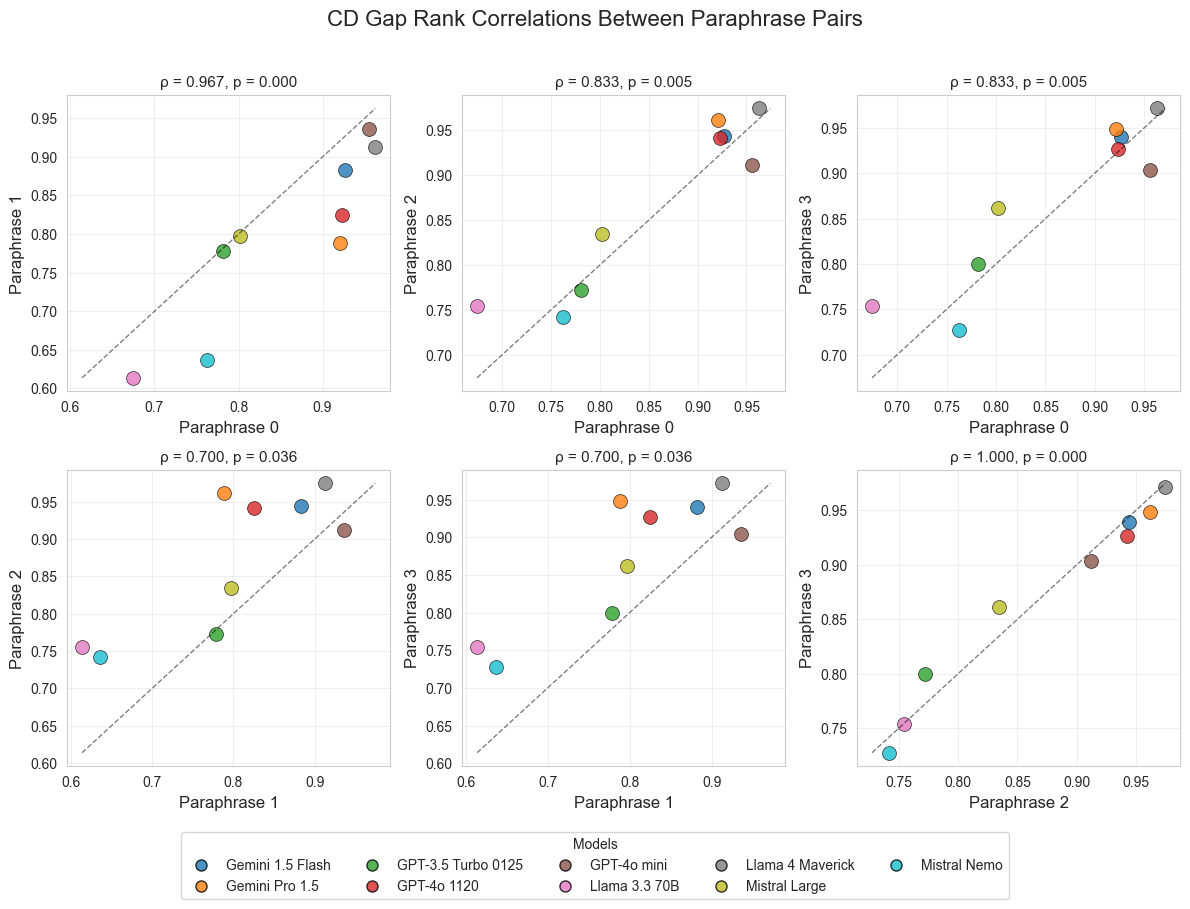

Paraphrase Pair Rank Correlations (Overall_utility)
Paraphrase 0 vs vs Paraphrase 1: ρ = 0.9667, p = 0.0000
Paraphrase 0 vs vs Paraphrase 2: ρ = 0.8333, p = 0.0053
Paraphrase 0 vs vs Paraphrase 3: ρ = 0.8333, p = 0.0053
Paraphrase 1 vs vs Paraphrase 2: ρ = 0.7000, p = 0.0358
Paraphrase 1 vs vs Paraphrase 3: ρ = 0.7000, p = 0.0358
Paraphrase 2 vs vs Paraphrase 3: ρ = 1.0000, p = 0.0000


In [15]:
from scipy.stats import spearmanr
import seaborn as sns
import matplotlib.pyplot as plt

judge_ids = all_merged_df.para_id.unique()
def p_to_stars(p_val):
    """Convert p-value to significance stars"""
    if pd.isna(p_val):
        return ""
    elif p_val < 0.001:
        return "***"
    elif p_val < 0.01:
        return "**"
    elif p_val < 0.05:
        return "*"
    else:
        return ""

# Calculate rank correlations between paraphrases for delta_CD
model_judge_deltas_pivot = model_judge_deltas.pivot(index='model_id', columns='para_id', values=metric)

# Calculate Spearman rank correlations between all paraphrase pairs
judge_pairs = []
correlations = []
p_values = []

for i, judge1 in enumerate(model_judge_deltas_pivot.columns):
    for j, judge2 in enumerate(model_judge_deltas_pivot.columns):
        if i < j:  # Only compute upper triangle
            # Filter out NaN values for correlation calculation
            valid_mask = model_judge_deltas_pivot[judge1].notna() & model_judge_deltas_pivot[judge2].notna()
            if valid_mask.sum() >= 3:  # Need at least 3 valid pairs for correlation
                corr, p_val = spearmanr(
                    model_judge_deltas_pivot[judge1][valid_mask],
                    model_judge_deltas_pivot[judge2][valid_mask]
                )
            else:
                corr, p_val = np.nan, np.nan

            judge_pairs.append(f"Paraphrase {judge1} vs\nParaphrase {judge2}")
            correlations.append(corr)
            p_values.append(p_val)

# Create subplots for each paraphrase pair comparison
n_pairs = len(correlations)
n_cols = 3  # 3 columns per row
n_rows = (n_pairs + n_cols - 1) // n_cols  # Calculate number of rows needed

fig, axes = plt.subplots(n_rows, n_cols, figsize=(4 * n_cols, 4 * n_rows))

# Handle case where we have multiple rows
if n_rows == 1:
    axes = axes.reshape(1, -1)
elif n_pairs == 1:
    axes = axes.reshape(-1, 1)

# Flatten axes for easier indexing
axes = axes.flatten()

# Hide unused subplots
for i in range(n_pairs, len(axes)):
    axes[i].set_visible(False)

# Define colors for each model
model_names = model_judge_deltas_pivot.index
n_models = len(model_names)
model_colors = plt.cm.tab10(np.linspace(0, 1, n_models))
model_color_map = dict(zip(model_names, model_colors))

# Create scatter plots for each paraphrase pair
available_pairs = [(judge_ids[i], judge_ids[j]) for i in range(len(judge_ids)) for j in range(i+1, len(judge_ids))]

for idx, (judge1, judge2) in enumerate(available_pairs[:len(axes)]):
    ax = axes[idx]

    x_vals = model_judge_deltas_pivot[judge1]
    y_vals = model_judge_deltas_pivot[judge2]

    # Filter out NaN values for plotting
    valid_mask = x_vals.notna() & y_vals.notna()

    if valid_mask.sum() > 0:
        # Plot each model with its unique color
        for k, model_id in enumerate(x_vals.index):
            if valid_mask.iloc[k]:
                model_name = model_metadata[model_metadata['model_id'] == model_id]['model_name'].iloc[0]
                x, y = x_vals.iloc[k], y_vals.iloc[k]

                ax.scatter(x, y,
                          color=model_color_map[model_id],
                          s=100,
                          alpha=0.8,
                          edgecolor='black',
                          linewidth=0.5,
                          label=model_name if idx == 0 else "")  # Only label once

        # Add correlation info and formatting
        ax.set_xlabel(f'Paraphrase {judge1}', fontsize=12)
        ax.set_ylabel(f'Paraphrase {judge2}', fontsize=12)

        if not np.isnan(correlations[idx]):
            ax.set_title(f'ρ = {correlations[idx]:.3f}, p = {p_values[idx]:.3f}', fontsize=11)
        else:
            ax.set_title('Insufficient data', fontsize=11)

        ax.grid(True, alpha=0.3)

        # Add diagonal line for reference
        valid_x = x_vals[valid_mask]
        valid_y = y_vals[valid_mask]
        if len(valid_x) > 0 and len(valid_y) > 0:
            min_val = min(valid_x.min(), valid_y.min())
            max_val = max(valid_x.max(), valid_y.max())
            ax.plot([min_val, max_val], [min_val, max_val], 'k--', alpha=0.5, linewidth=1)

# Add shared legend for models (only show for models with data in multiple paraphrases)
models_with_multiple_data = model_judge_deltas_pivot.count(axis=1) > 1
if models_with_multiple_data.sum() > 0 and models_with_multiple_data.sum() <= 10:
    model_legend_elements = [
        plt.Line2D([0], [0], marker='o', color='w',
                   markerfacecolor=model_color_map[model_id],
                   markersize=8, alpha=0.8, markeredgecolor='black',
                   label=model_metadata[model_metadata['model_id'] == model_id]['model_name'].iloc[0])
        for model_id in model_names if models_with_multiple_data[model_id]
    ]

    fig.legend(handles=model_legend_elements, loc='center', bbox_to_anchor=(0.5, -0.05),
              ncol=min(5, len(model_legend_elements)), fontsize=10, title='Models')

plt.suptitle('CD Gap Rank Correlations Between Paraphrase Pairs', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

# Print summary table
print(f"Paraphrase Pair Rank Correlations ({metric})")
print("=" * 50)
for pair, corr, p_val in zip(judge_pairs, correlations, p_values):
    if not np.isnan(corr):
        print(f"{pair.replace(chr(10), ' vs ')}: ρ = {corr:.4f}, p = {p_val:.4f}")
    else:
        print(f"{pair.replace(chr(10), ' vs ')}: Insufficient data for correlation")



In [16]:
# Create correlation matrix for heatmap
judge_rank_corr_matrix = pd.DataFrame(index=judge_ids, columns=judge_ids)

# Fill in the correlation matrix
for i, judge1 in enumerate(judge_ids):
    for j, judge2 in enumerate(judge_ids):
        if i == j:
            judge_rank_corr_matrix.loc[judge1, judge2] = 1.0
        else:
            # Find the correlation from our previous calculation
            for pair_idx, (pair, corr, p_val) in enumerate(zip(judge_pairs, correlations, p_values)):
                if (judge1 in pair and
                    judge2 in pair):
                    judge_rank_corr_matrix.loc[judge1, judge2] = corr
                    judge_rank_corr_matrix.loc[judge2, judge1] = corr

# Convert to numeric
judge_rank_corr_matrix = judge_rank_corr_matrix.astype(float)

# Create heatmap with proper labels
judge_labels = [judge for judge in judge_ids]
judge_rank_corr_matrix.index = judge_labels
judge_rank_corr_matrix.columns = judge_labels


# Also print the correlation matrix as a formatted table
print(f"Judge Rank Correlation Matrix ({metric})")
print("=" * 50)
print(judge_rank_corr_matrix.round(4).to_string())

Judge Rank Correlation Matrix (Overall_utility)
        0       1       2       3
0  1.0000  0.9667  0.8333  0.8333
1  0.9667  1.0000  0.7000  0.7000
2  0.8333  0.7000  1.0000  1.0000
3  0.8333  0.7000  1.0000  1.0000


In [230]:
# Calculate the frequency of 'Other' selection per model and per judge
# We'll use wide_dec, which contains *_Other columns for each category

# Find all columns ending with '_Other'
other_cols = [col for col in all_merged_df.columns if col.endswith('_Other')]

# Calculate mean proportion of 'Other' per model and judge (across all samples, categories)
other_per_model_judge = (
    all_merged_df
    .groupby(['model_id', 'para_id'])[other_cols]
    .mean()
    .assign(Overall_Other=lambda d: d.mean(axis=1))
    .reset_index()
)

# Add model names for readability
other_per_model_judge = other_per_model_judge.merge(model_metadata[['model_id', 'model_name']], on='model_id', how='left')

# Sort by judge and overall 'Other' frequency
other_per_model_judge = other_per_model_judge.sort_values(['model_name','para_id'], ascending=[True, True])

# Show the result
display_cols = ['para_id', 'model_name', 'Overall_Other']  # + other_cols for details
print(other_per_model_judge[display_cols].round(4))

   para_id          model_name  Overall_Other
8        0  GPT-3.5 Turbo 0125         0.0132
9        1  GPT-3.5 Turbo 0125         0.0246
10       2  GPT-3.5 Turbo 0125         0.0184
11       3  GPT-3.5 Turbo 0125         0.0132
12       0         GPT-4o 1120         0.0001
13       1         GPT-4o 1120         0.0000
14       2         GPT-4o 1120         0.0000
15       3         GPT-4o 1120         0.0000
16       0         GPT-4o mini         0.0008
17       1         GPT-4o mini         0.0003
18       2         GPT-4o mini         0.0000
19       3         GPT-4o mini         0.0003
0        0    Gemini 1.5 Flash         0.0021
1        1    Gemini 1.5 Flash         0.0001
2        2    Gemini 1.5 Flash         0.0008
3        3    Gemini 1.5 Flash         0.0019
4        0      Gemini Pro 1.5         0.0020
5        1      Gemini Pro 1.5         0.0018
6        2      Gemini Pro 1.5         0.0002
7        3      Gemini Pro 1.5         0.0011
20       0       Llama 3.3 70B    